Importamos las librerías necesarias

In [1]:
import matplotlib.pyplot as plt
import cornac
import pandas as pd
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, Precision, MAE, RMSE
from cornac.models import ItemKNN, BPR, MF
from cornac.eval_methods import RatioSplit
from sklearn.metrics.pairwise import cosine_similarity


Cargar el dataset de MovieLens 100K

In [2]:
data = movielens.load_feedback()
# Cargar la información de las películas desde el archivo 'u.item'


file_path = "datasets/ml-100k/u.data"
utility = pd.read_csv(file_path, sep='\t', header=None, encoding='latin-1')
utility.columns =['user_id', 'item_id', 'rating', 'timestamp']

file_path  = "datasets/ml-100k/u.item"
movies = pd.read_csv(file_path, sep='|', header=None, encoding='latin-1')

movies.columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


movie_genres = movies[genre_columns]
movie_similarities = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {movie_similarities.shape}")

print(type(movie_similarities))
print(movie_similarities)

Dimensions of our genres cosine similarity matrix: (1682, 1682)
<class 'numpy.ndarray'>
[[1.         0.         0.         ... 0.         0.57735027 0.        ]
 [0.         1.         0.57735027 ... 0.         0.         0.        ]
 [0.         0.57735027 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.70710678]
 [0.57735027 0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.70710678 0.         1.        ]]


In [3]:
sim_movies = {}
for idx in range(len(movie_similarities)):
    sim_scores = list(enumerate(movie_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_movies[idx] = sim_scores

In [4]:
def user_rated_movies(user_id, train_set):
    rated_movies = []
    for row in train_set:
        if row['user_id'] == user_id:
            rated_movies.append((row['item_id'], row['rating'], row['timestamp']))
    
    rated_movies.sort(key=lambda x: x[2])
    return rated_movies

# Example usage:
# user_id = 1
# rated_movies = user_rated_movies(user_id, train_set)
# print(rated_movies)


Crear modelos propios

In [5]:
class Hybrid(cornac.models.Recommender):
    def __init__(self, models, weights, name="Hybrid"):
        super().__init__(name=name)
        self.models = models
        self.weights = weights

    def fit(self, train_set, eval_set):
        super().fit(train_set,eval_set)
        for m in self.models:
            m.fit(train_set, eval_set)

    def score(self, user_idx, item_idx=None):
        ponderated_sum = 0
        # if each weight is 1/len(weights)then the score is the average  
        for idx in range(len(self.models)):
            ponderated_sum += self.models[idx].score(user_idx, item_idx)*self.weights[idx]

        return ponderated_sum/sum(self.weights)

class DHybrid(Hybrid):
    def __init__(self, models, weights, name="Hybrid"):
        super().__init__(models, weights, name)
        
    def fit(self, train_set, eval_set):
        print('Fit')
        super().fit(train_set, eval_set)
        
    def score(self, user_idx, item_idx=None):
        return super().score(user_idx, item_idx)
    
    def recommend(self, user_id, k=-1, remove_seen=False, train_set=None, n = 3):
        print('recommend')
        recommendations = super().recommend(user_id, k, remove_seen, train_set)
        idx = user_rated_movies(user_id, train_set)
        sim_scores = sim_movies[idx]
        similar_movies = [i[0] for i in sim_scores[:5]]
        return recommendations.extend(similar_movies)
    

Definir el método de evaluación

In [6]:
ratio_split = RatioSplit(data=data, test_size=0.2, rating_threshold=4.0, exclude_unknowns=True, verbose=True)

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1657
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1657
Number of ratings = 19972
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1657


Definir los modelos a emplear

In [7]:
mf = MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
svd = cornac.models.SVD()
knn = ItemKNN(k=20, similarity='cosine', name='ItemKNN')
bpr = cornac.models.BPR(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
hybrid = DHybrid([svd, bpr, knn], (6,3,1))

Definir las metricas a utilizar

In [8]:
metrics = []
metrics.append(MAE())
metrics.append(RMSE())
metrics.append(Recall(10))
metrics.append(Precision(10))

Definir el experimento


In [9]:
experiment = cornac.Experiment(eval_method=ratio_split, models=[mf, bpr, svd, knn, hybrid], metrics=metrics)

Ejecutar el experimento

In [10]:
experiment.run()


[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/19972 [00:00<?, ?it/s]

Ranking:   0%|          | 0/941 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/19972 [00:00<?, ?it/s]

Ranking:   0%|          | 0/941 [00:00<?, ?it/s]


[SVD] Training started!

[SVD] Evaluation started!


Rating:   0%|          | 0/19972 [00:00<?, ?it/s]

Ranking:   0%|          | 0/941 [00:00<?, ?it/s]


[ItemKNN] Training started!


  0%|          | 0/1657 [00:00<?, ?it/s]


[ItemKNN] Evaluation started!


Rating:   0%|          | 0/19972 [00:00<?, ?it/s]

Ranking:   0%|          | 0/941 [00:00<?, ?it/s]


[Hybrid] Training started!
Fit


  0%|          | 0/1657 [00:00<?, ?it/s]


[Hybrid] Evaluation started!


Rating:   0%|          | 0/19972 [00:00<?, ?it/s]

Ranking:   0%|          | 0/941 [00:00<?, ?it/s]


TEST:
...
        |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) | Test (s)
------- + ------ + ------ + ------------ + --------- + --------- + --------
MF      | 0.7525 | 0.9064 |       0.0698 |    0.0449 |    0.1537 |   1.5481
BPR     | 2.1562 | 2.3557 |       0.1168 |    0.1236 |    0.1182 |   5.3283
SVD     | 0.7610 | 0.9158 |       0.0590 |    0.0399 |    0.0869 |   2.6589
ItemKNN | 0.8286 | 1.0002 |       0.0271 |    0.0162 |    0.1662 |   9.0514
Hybrid  | 0.9712 | 1.1314 |       0.1642 |    0.1433 |    0.3716 |   9.8484



Extraer los resultados de las métricas

In [11]:
results = experiment.result
mean_mae = results[0].metric_avg_results['MAE']
mean_rmse = results[0].metric_avg_results['RMSE']
mean_precision = results[0].metric_avg_results['Precision@10']
mf_mae = results[1].metric_avg_results['MAE']
mf_rmse = results[1].metric_avg_results['RMSE']
mf_precision = results[1].metric_avg_results['Precision@10']
bpr_mae = results[2].metric_avg_results['MAE']
bpr_rmse = results[2].metric_avg_results['RMSE']
bpr_precision = results[2].metric_avg_results['Precision@10']
svd_mae = results[3].metric_avg_results['MAE']
svd_rmse = results[3].metric_avg_results['RMSE']
svd_precision = results[3].metric_avg_results['Precision@10']
knn_mae = results[4].metric_avg_results['MAE']
knn_rmse = results[4].metric_avg_results['RMSE']
knn_precision = results[4].metric_avg_results['Precision@10']

Crear un gráfico de barras para mostrar los resultados

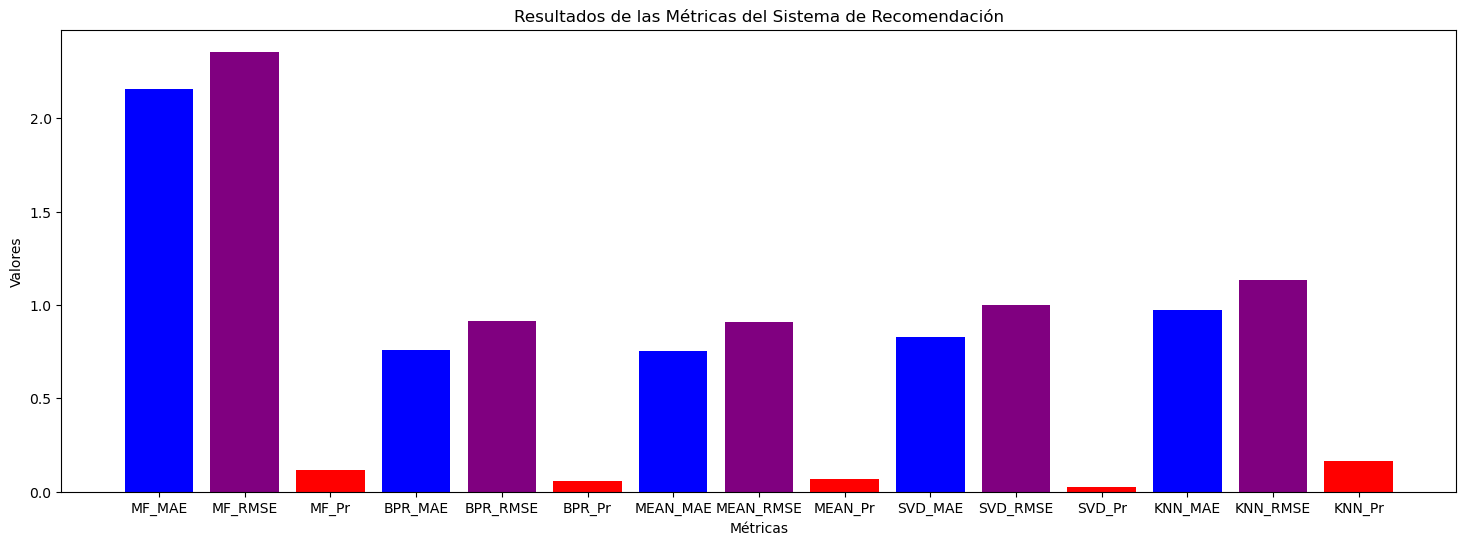

In [12]:
metrics_names = ['MF_MAE', 'MF_RMSE', 'MF_Pr', 'BPR_MAE', 'BPR_RMSE', 'BPR_Pr', 'MEAN_MAE', 'MEAN_RMSE', 'MEAN_Pr', 'SVD_MAE', 'SVD_RMSE', 'SVD_Pr', 'KNN_MAE', 'KNN_RMSE', 'KNN_Pr']
values = [mf_mae, mf_rmse, mf_precision, bpr_mae, bpr_rmse, bpr_precision, mean_mae, mean_rmse, mean_precision, svd_mae, svd_rmse, svd_precision, knn_mae, knn_rmse, knn_precision] 

plt.figure(figsize=(18, 6))
plt.bar(metrics_names, values, color=['blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Resultados de las Métricas del Sistema de Recomendación')
plt.show()
